In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import ascii
import time
import os
import apogee_tools as ap

In [3]:
data = ap.Spectrum(id='2M01195227+8409327', type='ap1d')
data.mask(sigma=[.3,.01], pixel_buffer=[0,3])
data.flux = data.flux/max(data.flux[np.isfinite(data.flux)])

mdl = ap.getModel(params=[3200, 5.0, 0.0], grid='BTSETTL', xrange=[15200,16940])

BTSETTL: [3200, 5.0, 0.0]


In [51]:
params = {'teff': 3100, 'logg': 5.5, 'z': -0.3, 'vsini': 0.1, 'rv': -41, 'alpha': .5}

times = []
t0 = time.time()

times.append(time.time() - t0)
interp_sp = ap.interpolateGrid(labels=[params['teff'], params['logg'], params['z']], res='500k')

times.append(time.time() - t0)
interp_sp.flux = interp_sp.flux/max(interp_sp.flux)

times.append(time.time() - t0)
rv_sp   = ap.rvShiftSpec(interp_sp, rv=params['rv'])

times.append(time.time() - t0)
rot_sp  = ap.applyVsini(rv_sp, vsini=params['vsini'])

times.append(time.time() - t0)
tell_sp = ap.applyTelluric(rot_sp, alpha=params['alpha'], airmass='1.0')

times.append(time.time() - t0)
lsf_sp  = ap.convolveLsf(tell_sp, fiber=124)

times.append(time.time() - t0)

Downsampled telluric spectrum resolution to model resolution.


/home/jess/Desktop/astro_code/apogee_tools/apogee_tools/apogee_hack/spec/lsf.py:176: RuntimeWarning: invalid value encountered in less
  out[out<0.]= 0.
/home/jess/Desktop/astro_code/apogee_tools/apogee_tools/apogee_hack/spec/lsf.py:177: RuntimeWarning: invalid value encountered in true_divide
  out/= numpy.tile(numpy.sum(out,axis=1),(len(x),1)).T


In [60]:
for i in np.diff(times):
    print(round(i,3))

0.044
0.024
0.013
0.024
42.261
24.876


In [58]:
interp_sp = ap.interpolateGrid(labels=[params['teff'], params['logg'], params['z']], res='500k')
interp_sp.flux = interp_sp.flux/max(interp_sp.flux)
rv_sp   = ap.rvShiftSpec(interp_sp, rv=params['rv'])
rot_sp  = ap.applyVsini(rv_sp, vsini=params['vsini'])

In [62]:
t0 = time.time()
lsf_sp  = ap.convolveLsf(tell_sp, fiber=124)
print(time.time() - t0)

/home/jess/Desktop/astro_code/apogee_tools/apogee_tools/apogee_hack/spec/lsf.py:176: RuntimeWarning: invalid value encountered in less
  out[out<0.]= 0.
/home/jess/Desktop/astro_code/apogee_tools/apogee_tools/apogee_hack/spec/lsf.py:177: RuntimeWarning: invalid value encountered in true_divide
  out/= numpy.tile(numpy.sum(out,axis=1),(len(x),1)).T


24.875438928604126


In [5]:
bands = [[15200,15800],[15860,16425],[16475,16935]]
cont_sp = ap.continuum(data, lsf_sp, bands=bands, norm=True, deg=5)

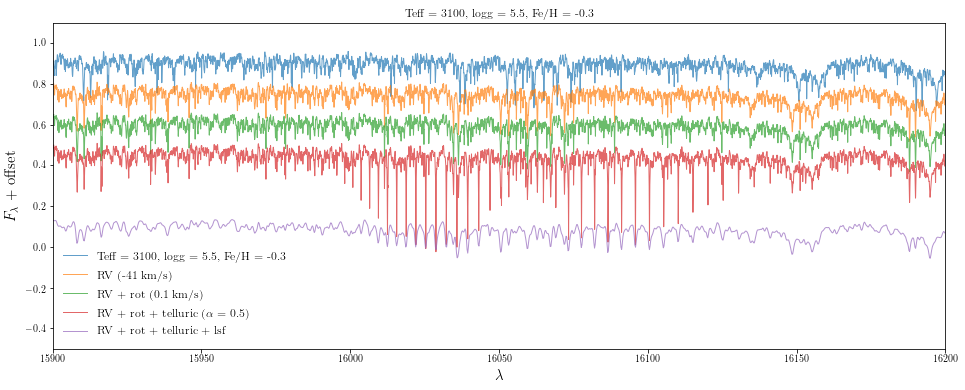

In [71]:
plt.figure(1, figsize=(16,6))  
plt.plot(interp_sp.wave, interp_sp.flux, alpha=.7, linewidth=1, label=r'Teff = %s, logg = %s, Fe/H = %s'%(params['teff'], params['logg'], params['z']))
plt.plot(rv_sp.wave, rv_sp.flux-.15, label=r'RV (%s km/s)'%(params['rv']), alpha=.7, linewidth=1)
plt.plot(rot_sp.wave, rot_sp.flux-.3, label=r'RV + rot (%s km/s)'%(params['vsini']), alpha=.7, linewidth=1)
plt.plot(tell_sp.wave, tell_sp.flux-.45, label=r'RV + rot + telluric ($\alpha$ = %s)'%(params['alpha']), alpha=.7, linewidth=1)
plt.plot(lsf_sp.wave, lsf_sp.flux-.8, label=r'RV + rot + telluric + lsf', alpha=.7, linewidth=1)
# plt.plot(cont_sp.wave, cont_sp.flux-.9, label=r'RV + rot + telluric + lsf + continuum', alpha=.7, linewidth=1)

plt.xlim([15900,16200]) #[15190,16950]
plt.ylim(-.5, 1.1)
plt.legend(loc='lower left', frameon=False, fontsize=12)
plt.ylabel(r'$F_{\lambda}$ + offset', fontsize=15)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.title('Teff = %s, logg = %s, Fe/H = %s'%(params['teff'], params['logg'], params['z']))
plt.show()

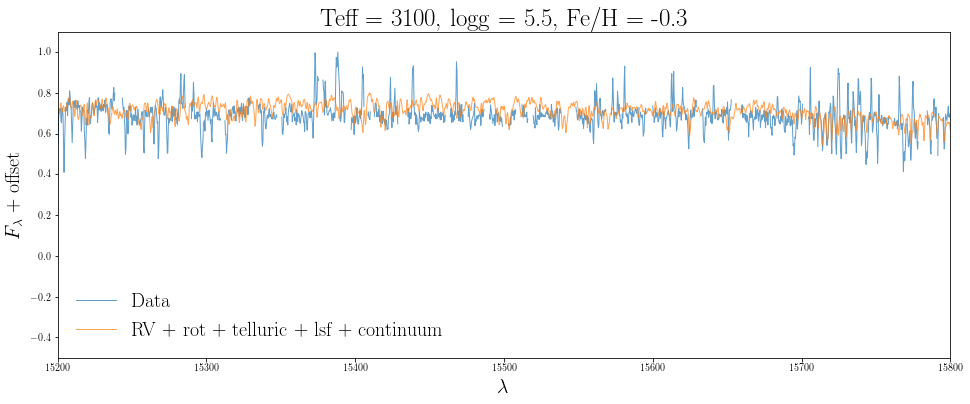

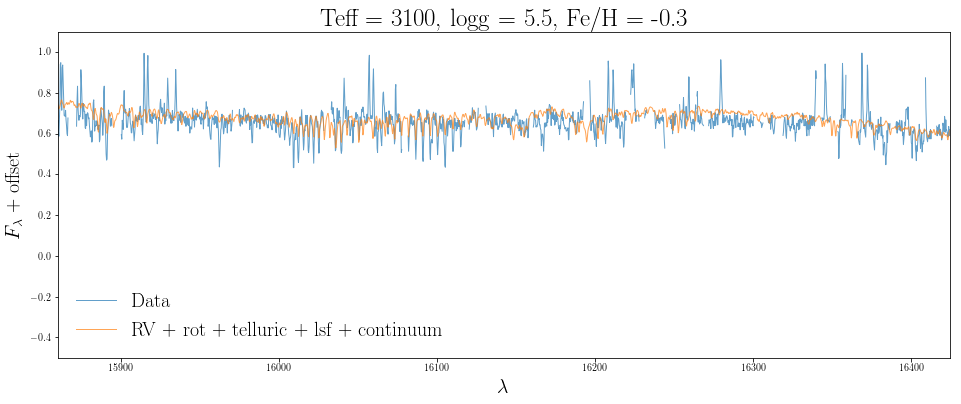

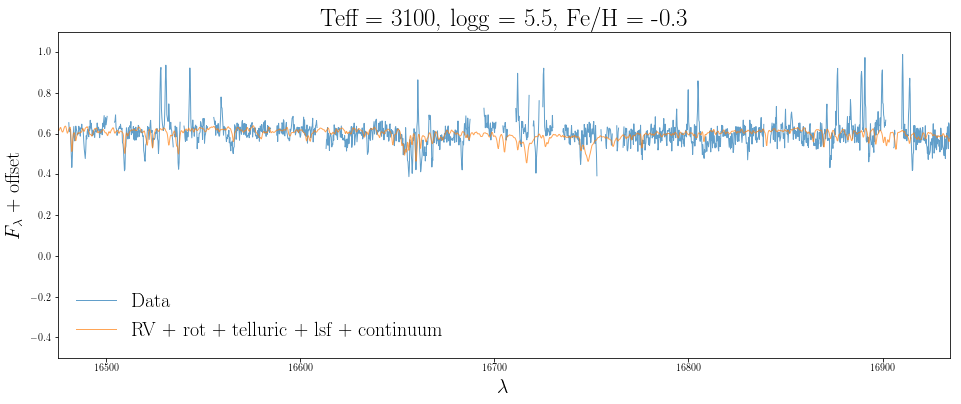

In [6]:
for i in range(len(bands)):
    plt.figure(1, figsize=(16,6))  
    plt.plot(data.wave, data.flux, label=r'Data', alpha=.7, linewidth=1)
    plt.plot(cont_sp.wave, cont_sp.flux-.2, label=r'RV + rot + telluric + lsf + continuum', alpha=.7, linewidth=1)

    plt.xlim(bands[i]) #[15190,16950]
    plt.ylim(-.5, 1.1)
    plt.legend(loc='lower left', frameon=False, fontsize=20)
    plt.ylabel(r'$F_{\lambda}$ + offset', fontsize=20)
    plt.xlabel(r'$\lambda$', fontsize=20)
    plt.title('Teff = %s, logg = %s, Fe/H = %s'%(params['teff'], params['logg'], params['z']), fontsize=25)
    plt.show()

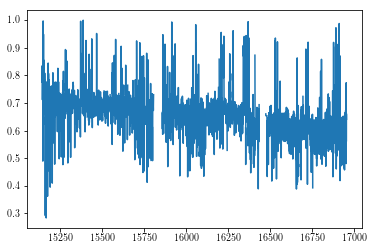

In [30]:
plt.plot(data.wave, data.flux)
# plt.plot(lsf_sp.wave, lsf_sp.flux)
plt.show()

In [22]:
def calcScale(sp1, sp2):

    wave1, flux1 = sp1.wave, sp1.flux
    unc = sp1.sigmas

    # interpolate spectrum 2 to the array size of spectrum 1
    wave2 = wave1
    flux2 = np.interp(wave1, sp2.wave, sp2.flux)

    a = sum(flux2*flux1/unc**2)
    b = sum(flux2**2/unc**2)

    scale = a/b
    
    print('scale', scale)

    return scale

def compareSpectra(sp1, sp2, **kwargs):

    fit_range = kwargs.get('fit_range', [sp1.wave[0], sp1.wave[-1]])
    fit_scale = kwargs.get('fit_scale', True)
    normalize = kwargs.get('norm', True)
    ivariance = kwargs.get('ivar', False)

    from scipy.interpolate import interp1d

    #sp2 will be interpolated to the same wavelenth values as sp1
    wave1 = sp1.wave
    flux1 = sp1.flux
    if ivariance == True:
        ivar = sp1.ivar
    else:
        unc  = sp1.sigmas

    #Interpolation function 
    f = interp1d(sp2.wave, sp2.flux, bounds_error=False, fill_value=0.)
    flux2 = f(wave1)

    #Create a new spectrum object for sp2
    sp2 = ap.Spectrum(wave=wave1, flux=flux2, params=sp2.params)

    #Compute scale factor for 2nd spectrum
    if fit_scale == True:
        scale = calcScale(sp1, sp2)
    else:
        scale = 1

    #Compute chi-squared value
    flux2 = scale*flux2
    diff = flux1 - flux2
    if ivariance == True:
        stat = (diff**2)*ivar
    else:
        stat = diff**2/np.array(unc)**2
    chi = np.nansum(stat)

    sp2 = ap.Spectrum(wave=wave1, flux=flux2, params=sp2.params)

    return chi, sp1, sp2

In [27]:
sp_new = cont_sp
sp_new.flux = sp_new.flux-.2
compareSpectra(data, sp_new, fit_scale=False)[0]

0.12891523258006293

In [32]:
compareSpectra(data, lsf_sp, fit_scale=False)[0]

42151939821150.68

In [6]:
vals = [0.124966,0.124967,0.124967,0.124968,0.124968,0.124968,0.124968,0.124968,0.124969,0.124969,0.124969,0.124968,0.124968,0.124968,0.124969,0.124969,0.124969,0.124969,0.124969,0.12497,0.12497,0.12497,0.12497,0.12497,0.12497,0.124971,0.124972,0.124972,0.124973,0.124974,0.124974,0.124975,0.124976,0.124976,0.124977,0.124977,0.124978,0.124978,0.124978,0.124979,0.124979,0.124979,0.12498,0.124981,0.124982,0.124982,0.124983,0.124984,0.124984,0.124985,0.124986,0.124987,0.124988,0.124988,0.124989,0.124989,0.12499,0.12499,0.12499,0.124991,0.124991,0.124991,0.124992,0.124992,0.124993,0.124993,0.124994,0.124994,0.124994,0.124994,0.124994,0.124994,0.124994,0.124994,0.124994,0.124994,0.124995,0.124995,0.124995,0.124995,0.124996,0.124997,0.124998,0.124998,0.124999,0.125,0.125001,0.125001,0.125002,0.125003,0.125004,0.125005,0.125006,0.125006,0.125007,0.125008,0.125009,0.125009,0.125009,0.125009,0.125009,0.12501,0.12501,0.125011,0.125012,0.125012,0.125013,0.125013,0.125013,0.125014,0.125014,0.125014,0.125015,0.125015,0.125015,0.125015,0.125016,0.125016,0.125016,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125016,0.125016,0.125016,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125014,0.125014,0.125014,0.125014,0.125014,0.125014,0.125015,0.125015,0.125016,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125016,0.125016,0.125016,0.125015,0.125015,0.125014,0.125014,0.125014,0.125013,0.125013,0.125013,0.125014,0.125013,0.125013,0.125013,0.125012,0.125011,0.125011,0.12501,0.12501,0.125009,0.125009,0.125008,0.125007,0.125006,0.125005,0.125004,0.125004,0.125003,0.125002,0.125002,0.125001,0.125,0.124999,0.124998,0.124998,0.124997,0.124997,0.124996,0.124996,0.124996,0.124995,0.124995,0.124994,0.124994,0.124994,0.124995,0.124995,0.124995,0.124995,0.124995,0.124995,0.124995,0.124996,0.124996,0.124996,0.124997,0.124997,0.124996,0.124996,0.124996,0.124997,0.124997,0.124998,0.124998,0.124999,0.124999,0.124999,0.124999,0.125,0.125,0.125001,0.125002,0.125002,0.125003,0.125004,0.125005,0.125005,0.125006,0.125007,0.125008,0.125008,0.125009,0.125009,0.125009,0.125009,0.125009,0.125008,0.125008,0.125007,0.125007,0.125008,0.125008,0.125008,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125008,0.125008,0.125009,0.125009,0.125009,0.125008,0.125008,0.125008,0.125008,0.125008,0.125008,0.125008,0.125007,0.125007,0.125006,0.125006,0.125006,0.125005,0.125005,0.125005,0.125004,0.125004,0.125004,0.125003,0.125003,0.125003,0.125002,0.125002,0.125003,0.125003,0.125003,0.125003,0.125004,0.125004,0.125004,0.125004,0.125004,0.125004,0.125003,0.125004,0.125004,0.125004,0.125004,0.125004,0.125004,0.125004,0.125003,0.125003,0.125003,0.125002,0.125002,0.125003,0.125003,0.125004,0.125004,0.125004,0.125005,0.125005,0.125005,0.125006,0.125006,0.125006,0.125007,0.125007,0.125008,0.125008,0.125008,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009,0.125008,0.125008,0.125008,0.125007,0.125007,0.125007,0.125008,0.125008,0.125009,0.125008,0.125008,0.125008,0.125008,0.125007,0.125006,0.125006,0.125005,0.125004,0.125003,0.125002,0.125002,0.125001,0.125,0.125,0.124999,0.124999,0.124999,0.124998,0.124998,0.124998,0.124997,0.124997,0.124996,0.124996,0.124996,0.124996,0.124996,0.124996,0.124996,0.124996,0.124996,0.124995,0.124995,0.124995,0.124995,0.124995,0.124995,0.124995,0.124995,0.124995,0.124995,0.124995,0.124996,0.124996,0.124997,0.124997,0.124997,0.124998,0.124998,0.124999,0.125,0.125001,0.125002,0.125003,0.125004,0.125004,0.125005,0.125005,0.125006,0.125007,0.125008,0.125009,0.12501,0.12501,0.125011,0.125011,0.125012,0.125012,0.125013,0.125014,0.125014,0.125014,0.125014,0.125014,0.125014,0.125014,0.125014,0.125014,0.125015,0.125015,0.125015,0.125016,0.125016,0.125016,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125016,0.125016,0.125015,0.125015,0.125014,0.125013,0.125014,0.125014,0.125014,0.125014,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125015,0.125016,0.125016,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125017,0.125016,0.125016,0.125016,0.125015,0.125015,0.125015,0.125014,0.125014,0.125014,0.125013,0.125013,0.125012,0.125012,0.125011,0.125011,0.12501,0.12501,0.125009,0.125009,0.125009,0.125008,0.125008,0.125008,0.125007,0.125006,0.125005,0.125005,0.125004,0.125003,0.125002,0.125001,0.125,0.125,0.124999,0.124998,0.124998,0.124997,0.124996,0.124995,0.124995,0.124995,0.124995,0.124994,0.124994,0.124994,0.124994,0.124994,0.124994,0.124994,0.124994,0.124994,0.124994,0.124993,0.124993,0.124993,0.124992,0.124991,0.124991,0.12499,0.12499,0.12499,0.12499,0.124989,0.124989,0.124988,0.124988,0.124987,0.124986,0.124985,0.124985,0.124984,0.124983,0.124982,0.124982,0.124981,0.12498,0.124979,0.124979,0.124979,0.124979,0.124978,0.124978,0.124977,0.124977,0.124976,0.124976,0.124975,0.124975,0.124974,0.124973,0.124973,0.124972,0.124971,0.124971,0.12497,0.12497,0.12497,0.12497,0.12497,0.12497,0.12497,0.124969,0.124969,0.124969,0.124969,0.124969,0.124969,0.124969,0.124969,0.124969,0.124969,0.124969,0.124968,0.124968,0.124968,0.124967,0.124967,0.124966,0.124965]

In [11]:
xvals = np.linspace(-4,4,len(vals))

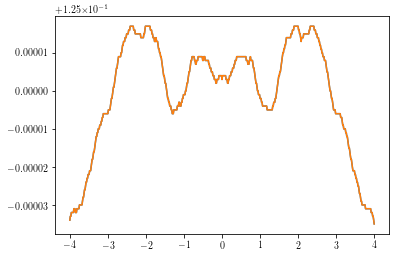

In [13]:
plt.plot(xvals,vals)
plt.show()